In [1]:
import torch
import torch.nn as nn
import clip
from PIL import Image
import pandas as pd
import requests
import os.path as osp
import pickle
import random
import numpy as np
from pathlib import Path
import sys
from operator import itemgetter
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time

In [2]:
class Timer:
    def __init__(self):

        self.t1 = None

    @staticmethod
    def delta_to_string(td):

        res_list = []

        def format():
            return ", ".join(reversed(res_list)) + " elapsed."

        seconds = td % 60
        td //= 60
        res_list.append(f"{round(seconds,3)} seconds")

        if td <= 0:
            return format()

        minutes = td % 60
        td //= 60
        res_list.append(f"{minutes} minutes")

        if td <= 0:
            return format()

        hours = td % 24
        td //= 24
        res_list.append(f"{hours} hours")

        if td <= 0:
            return format()

        res_list.append(f"{td} days")

        return format()

    def __enter__(self):

        self.t1 = time.time()

    def __exit__(self, *args, **kwargs):

        t2 = time.time()
        td = t2 - self.t1

        print(self.delta_to_string(td))


In [3]:
def image_path(uid):
    return osp.join(image_storage, f"{uid}.jpg")

In [4]:
def read_pickle(dir):
    with open(dir, 'rb') as handle:
        b = pickle.load(handle)
    return b


def write_pickle(dir, data):
    with open(dir, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [34]:
def find_products(text_input, data):
    print(f"finding products for query: {text_input}...")
    text_input = [text_input]
    
    data = data[~data["encoded_image"].isna()]
    image_uids = list(data["uid"].values)
    
    encoded_images = torch.cat(list(data["encoded_image"].values)).to(device)
    encoded_texts = clip.tokenize(text_input).to(device)
    
    with torch.no_grad():
        logits_per_image, logits_per_text = model(encoded_images, encoded_texts)
        probs = logits_per_text.softmax(dim=-1).cpu().numpy()
    
    res = dict(zip(image_uids, probs[0] * 100))
    res = dict(sorted(res.items(), key=itemgetter(1), reverse=True)[:5])
    
    return res


def show_images(res):
    n = len(res)
    fig, ax = plt.subplots(1, n)

    fig.set_figheight(5)
    fig.set_figwidth(5 * n)

    for i, image in enumerate(res.keys()):
        img_path = image_path(image)
        img = mpimg.imread(img_path)
        ax[i].imshow(img)
        ax[i].axis('off')
        # ax[i].set_title(get_label(image), fontsize=8)

    plt.subplots_adjust(wspace=0, hspace=0.1)
    plt.show()

In [5]:
dataset_path = "C:/Users/aphri/Documents/t0002/work/data/w210_data/target_store_furniture_datasets.csv"
image_storage = "C:/Users/aphri/Documents/t0002/work/data/w210_data/target_images"
pickle_path = "C:/Users/aphri/Documents/t0002/work/data/w210_data/pickle"
model_path = "C:/Users/aphri/Documents/t0002/work/data/w210_data/model"

Path(image_storage).mkdir(parents=True, exist_ok=True)
Path(pickle_path).mkdir(parents=True, exist_ok=True)
Path(model_path).mkdir(parents=True, exist_ok=True)

In [6]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [8]:
file = osp.join(pickle_path, "1000.pkl")
data = read_pickle(file)

In [9]:
data.head()

,uid,text,encoded_image,encoded_text
0,c456e14d-0693-5552-8f90-eead4a0f1f50,Desks,"[[[tensor([1.9303, 1.9303, 1.9303, 1.9303, 1.9...","[[tensor(49406, dtype=torch.int32), tensor(410..."
1,b020d91e-77ab-5c3e-b1e6-2fe01abe41b6,Dressers,"[[[tensor([1.9303, 1.9303, 1.9303, 1.9303, 1.9...","[[tensor(49406, dtype=torch.int32), tensor(126..."
2,d0972ad8-c10a-5d84-86a1-4d25cd361229,Beds,"[[[tensor([1.9303, 1.9303, 1.9303, 1.9303, 1.9...","[[tensor(49406, dtype=torch.int32), tensor(139..."
3,dade134d-f251-5120-97be-23eb1e01c0f8,Storage Furniture,"[[[tensor([1.9303, 1.9303, 1.9303, 1.9303, 1.9...","[[tensor(49406, dtype=torch.int32), tensor(682..."
4,f2e0d558-e93f-541b-98b1-6fff36f1dc89,Patio Chairs,"[[[tensor([1.9303, 1.9303, 1.9303, 1.9303, 1.9...","[[tensor(49406, dtype=torch.int32), tensor(143..."


finding products for query: I am looking for a large beige office chair...
1.0 minutes, 13.036 seconds elapsed.
{'8418e43d-3e12-597e-b446-ae483cf22327': 8.326147, 'a944a77b-e740-5ca0-9c59-4d53ab8f2b58': 7.440852, 'a6d19fa8-f218-53eb-b9fc-280c91a8930f': 7.198289, '71124924-6927-569a-9c40-b695e95d5187': 6.943235, '1e4d05fe-8d63-550a-afca-25b61ed95e43': 5.859204}


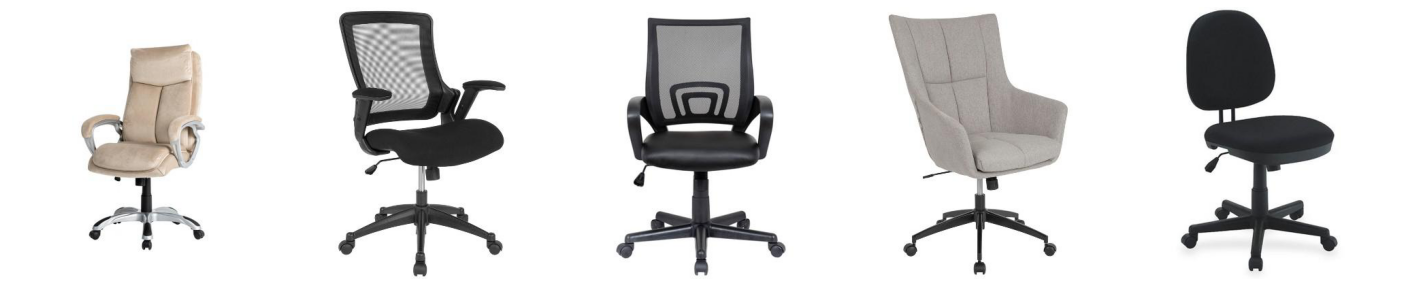

In [12]:
text_input = "I am looking for a large beige office chair"

with Timer():
    res1 = find_products(text_input, data)

print(res1)
show_images(res1)

In [14]:
import openai
openai.api_key = ''

User :  I am looking for a beige office chair.


ChatGPT: The user is looking for a beige office chair.
looking for products...
finding products for query: The user is looking for a beige office chair....


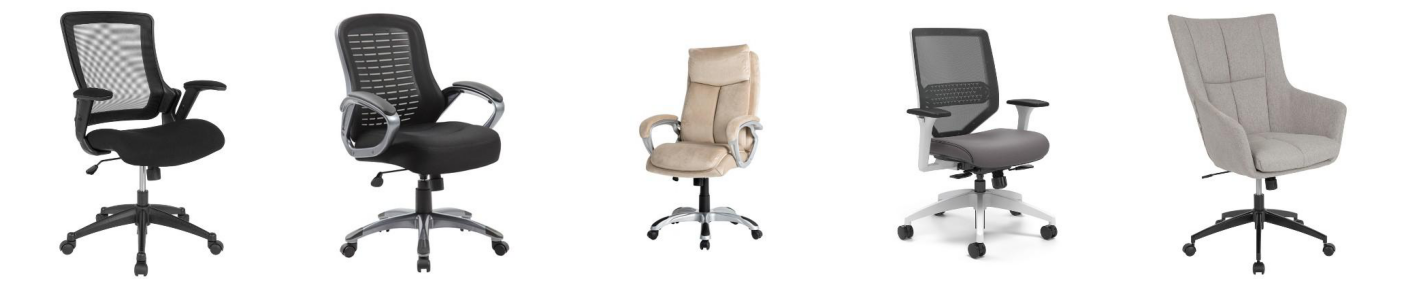

found products
1.0 minutes, 32.013 seconds elapsed.


User :  actually I am looking for something darker.


ChatGPT: The user is looking for a darker office chair.
looking for products...
finding products for query: The user is looking for a darker office chair....


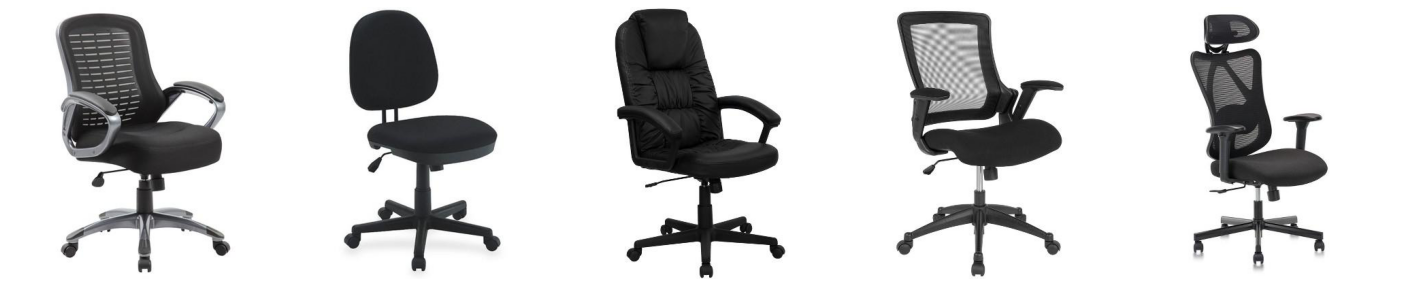

found products
1.0 minutes, 56.153 seconds elapsed.


User :  I don't like chairs with wheels though.


ChatGPT: The user is looking for a non-wheeled office chair in a darker shade.
looking for products...
finding products for query: The user is looking for a non-wheeled office chair in a darker shade....


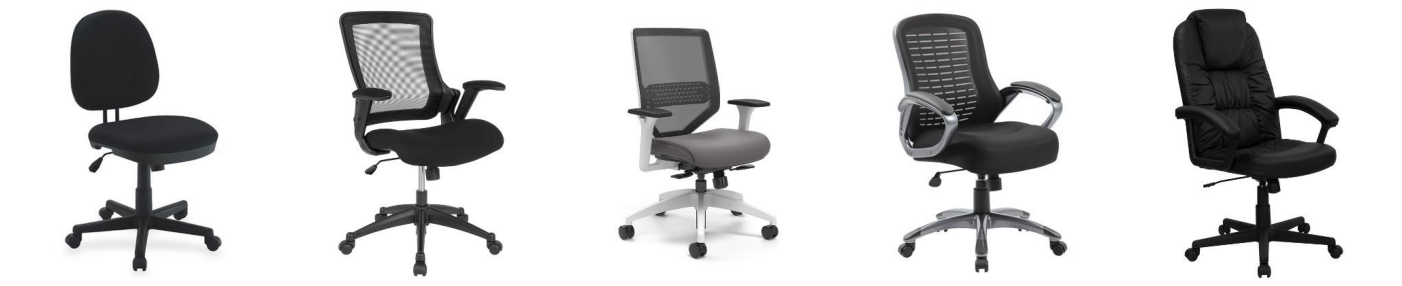

found products
2.0 minutes, 19.33 seconds elapsed.


User :  I changed my mind. I need the chair in red.


ChatGPT: The user is looking for a red office chair without wheels.
looking for products...
finding products for query: The user is looking for a red office chair without wheels....


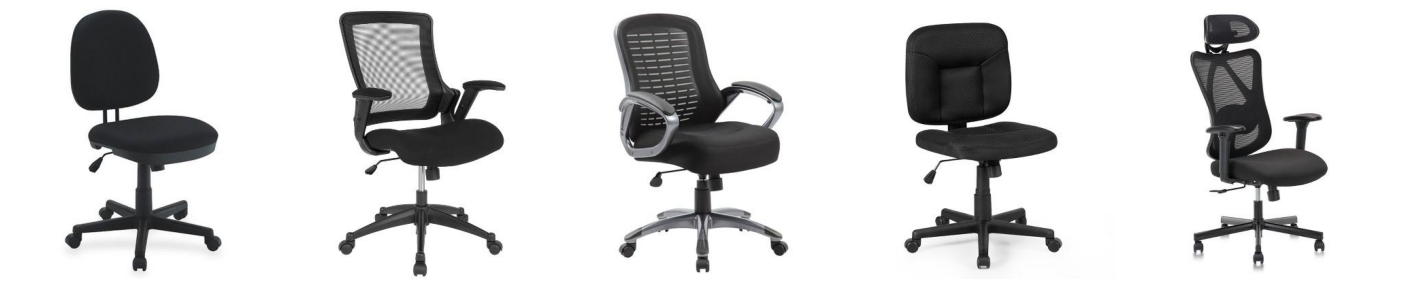

found products
1.0 minutes, 44.46 seconds elapsed.


In [ ]:
messages = []

res_list = []

prefix = "considering what the user asked before, what is the user looking for with the following request. Only respond with the product description no more than 30 words:"
while True:
    message = input("User : ")
    if message:
        messages.append(
            {"role": "user", "content": f"{prefix} {message}"},
        )
        chat = openai.ChatCompletion.create(
            model="gpt-3.5-turbo", messages=messages
        )
      
        reply = chat.choices[0].message.content
        print(f"ChatGPT: {reply}")
        
        with Timer():
            print("looking for products...")
            res_list.append(find_products(reply, data))
            show_images(res_list[-1])
            print("found products")
        
        messages.append({"role": "assistant", "content": reply})

In [ ]:
# this demo uses the first 1000 products in the dataset
# unfortunately there are no non-wheeled or red office chairs in the subset of data

# TODO
# append product description shown to chatGPT for history reference
# have chatGPT determine whether to search for image or ask for additional information
# also ask chatGPT whethere the user has ended the conversation.